In [1]:
# Module: Data Science in Finance, Orientation on the Credit risk case study
# Version 1.0
# Topic : Exploring Data sets to make sense in Python
# Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
# For support or questions, contact Sri Krishnamurthy at
# sri@quantuniversity.com
# Copyright 2016 QuantUniversity LLC.
#####################################################################

#  Exploring Data sets to make sense in Python

This notebook deals with understanding the lending data obtained from https://www.kaggle.com/wendykan/lending-club-loan-data

Imports

In [2]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Dataset

The data set is the lending data obtained from LendingClub from August 2011 to December 2011 for some borrowers. The feature descriptions for the data are also provided. Not all the features are required for making predictions, some features are redundant in the original data file. The provided data file is already cleaned and only relevant features are provided. There are two types of features, numerical and categorical.

Reading the input data from csv file.

In [3]:
df = pd.read_csv("../data/LendingClubLoan.csv", low_memory=False)
df_description = pd.read_excel('../data/LCDataDictionary.xlsx').dropna()
df_description.head(20)

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
6,delinq_2yrs,The number of 30+ days past-due incidences of ...
7,desc,Loan description provided by the borrower
8,dti,A ratio calculated using the borrower’s total ...
9,dti_joint,A ratio calculated using the co-borrowers' tot...


### Check shape of dataframe and columns types
Categorical features are represented as _object_ type. This dataset has 9999 samples with 17 features.

In [4]:
print(df.shape)
df.head()

(9999, 17)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
0,5000,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,11-Dec,credit_card,AZ,27.65,0,1,0
1,2500,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,11-Dec,car,GA,1.00,0,5,1
2,2400,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,11-Dec,small_business,IL,8.72,0,2,0
3,10000,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,11-Dec,other,CA,20.00,0,1,0
4,3000,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,11-Dec,other,OR,17.94,0,0,0


In [5]:
del df['issue_d'] # removing issue date as it wont affect the prediction (redundant feature)

### Distribution of data types in features
This data set have equal number of catgorical and numerical features.

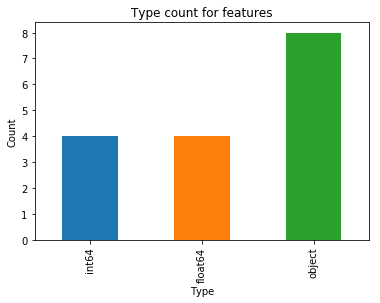

In [6]:
plt.title('Type count for features')
plt.xlabel('Type')
plt.ylabel('Count')
df.dtypes.value_counts().sort_values().plot(kind='bar')
plt.show()

## Catergorical and numerical data

### Correlation matrix for numerical data


We can calculate the corelation matrix for the given numerical features to see the relation or dependency of features among themselves. Each cell in the matrix describes the Pearson Correlation coefficient, a value between -1 and 1. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. This implies that we can usually estimate correlations pretty accurately from nothing more than scatterplots. +1 is highly linearly related and -1 is highly negatively linearly related. A fractional number indicates deviation from a linear trend. 

['loan_amnt' 'int_rate' 'installment' 'annual_inc' 'dti' 'delinq_2yrs'
 'inq_last_6mths' 'loan_status_Binary']


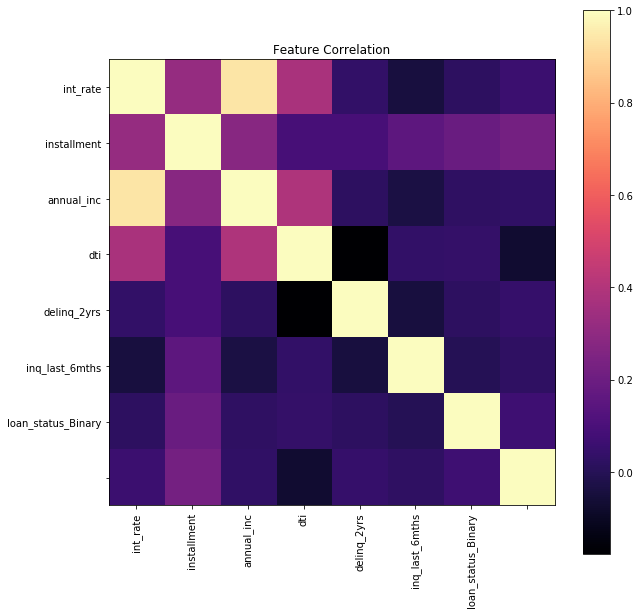

In [7]:
def correlation_matrix(df):
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('magma')
    corr = df.corr()
    cax = ax1.imshow(corr, interpolation="nearest", cmap=cmap)
    plt.title('Feature Correlation')
    labels = df.columns.values
    print(labels)
    ax1.set_xticklabels(corr.columns,fontsize=10, rotation=90)
    ax1.set_yticklabels(corr.columns,fontsize=10)
    fig.colorbar(cax)
    plt.show()

correlation_matrix(df.select_dtypes(include=['float64','int64']))

For the given dataset, it is evident fom the correlation matrix that the _installment_ is somewhat related to all other numerical features. Also, _interst rate_, _annual income_ and _dti_ have some sort of linear relationship.

### Preparing categorical features

Categorical data is best processed by algorithms when converted to numerical format.The most common way is by mapping each category to an integers. Ex. \[A, B, C\] can be mapped to \[0, 1, 2\]. Another way is one-hot encoding which we will look into while building the models.

Get a list of all numerical and categorical features

In [8]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

Change type from object to category

In [9]:
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [10]:
p_categories = df['purpose'].cat.categories.tolist()
s_categories = df['addr_state'].cat.categories.tolist()
print(dict( enumerate(df['purpose'].cat.categories) ))

df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

{0: 'car', 1: 'credit_card', 2: 'debt_consolidation', 3: 'home_improvement', 4: 'house', 5: 'major_purchase', 6: 'medical', 7: 'moving', 8: 'other', 9: 'renewable_energy', 10: 'small_business', 11: 'vacation', 12: 'wedding'}


## Summary of features

### Summary of categorical features

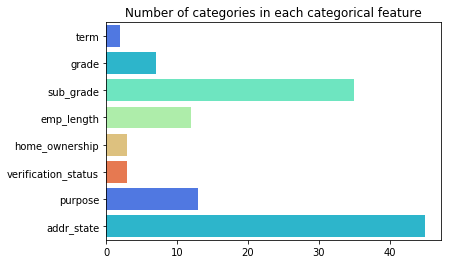

In [11]:
# Barplot
sns.barplot(y = categorical_columns, x = df[categorical_columns].apply(pd.Series.nunique, axis = 0).tolist(), palette=sns.color_palette("rainbow"))
plt.title('Number of categories in each categorical feature')
plt.show()

### Summary of numerical features

In [12]:
df.select_dtypes(include=['float64','int64']).describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
count,9999.000000,9999.000000,9999.000000,9.999000e+03,9999.000000,9999.000000,9999.000000,9999.000000
mean,12861.456146,12.428641,363.819195,7.027073e+04,13.989643,0.133513,0.849685,0.155616
std,8492.219046,4.239319,226.220788,4.832171e+04,6.612583,0.459694,1.040444,0.362509
min,1000.000000,5.420000,22.240000,6.000000e+03,0.000000,0.000000,0.000000,0.000000
25%,6000.000000,8.900000,193.580000,4.200000e+04,8.940000,0.000000,0.000000,0.000000
50%,11200.000000,12.420000,322.250000,6.000000e+04,14.020000,0.000000,1.000000,0.000000
75%,17500.000000,15.270000,480.330000,8.450000e+04,19.150000,0.000000,1.000000,0.000000
max,35000.000000,24.110000,1288.100000,1.782000e+06,29.920000,6.000000,8.000000,1.000000


### Summary of loan amounts

c:\users\atharva jakkanwar\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


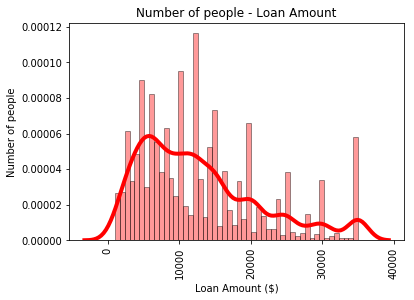

count     9999.000000
mean     12861.456146
std       8492.219046
min       1000.000000
25%       6000.000000
50%      11200.000000
75%      17500.000000
max      35000.000000
Name: loan_amnt, dtype: float64


In [13]:
# Histogram and density chart
sns.distplot(df['loan_amnt'], hist=True, kde=True, 
             bins=50, color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xticks(rotation=90)
plt.title('Number of people - Loan Amount')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of people')
plt.show()

print(df['loan_amnt'].describe())

### Summary of Annual incomes

c:\users\atharva jakkanwar\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


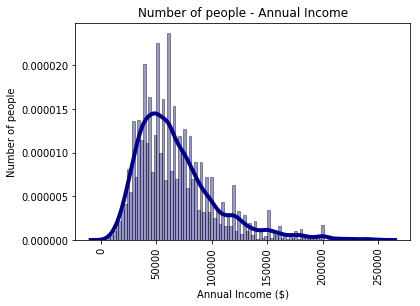

count    9.999000e+03
mean     7.027073e+04
std      4.832171e+04
min      6.000000e+03
25%      4.200000e+04
50%      6.000000e+04
75%      8.450000e+04
max      1.782000e+06
Name: annual_inc, dtype: float64


In [14]:
# Histogram and density chart
sns.distplot(df[df['annual_inc'] <250000]['annual_inc'], hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xticks(rotation=90)
plt.title('Number of people - Annual Income')
plt.xlabel('Annual Income ($)')
plt.ylabel('Number of people')
plt.show()

print(df['annual_inc'].describe())

### Loan Purposes distribution
By looking at the distribution, it can be seen that debt consolidation is one of the major resons for loan. In the given dataset, the number of samples having debt consolidation as the purpose are significantly more than other  purposes.

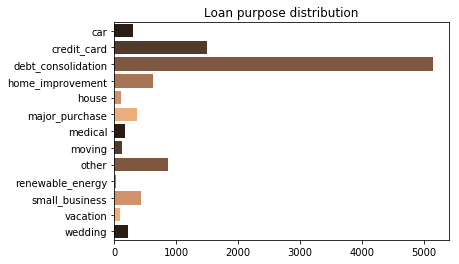

count    9999.000000
mean        3.303230
std         2.923144
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: purpose, dtype: float64


In [15]:
# Bar chart
sns.barplot(y = p_categories, x = df['purpose'].value_counts().sort_index().tolist(), palette=sns.color_palette("copper"))
plt.title('Loan purpose distribution')
plt.show()

# Summary
print(df['purpose'].describe())

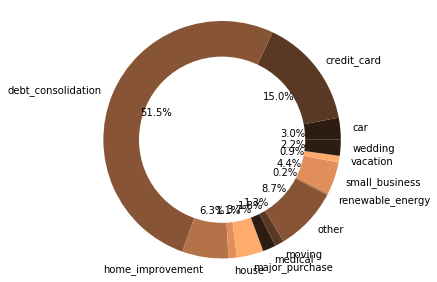

In [16]:
# Circle chart
fig1, ax1 = plt.subplots()
ax1.pie(df['purpose'].value_counts().sort_index().tolist(),
        labels=p_categories,
        autopct='%1.1f%%',
        colors= sns.color_palette("copper"))

ax1.axis('equal')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
  
plt.tight_layout()
plt.show()

### State wise customer distribution
The states of Californial has the highest number of borrowers followed by New York and Florida.

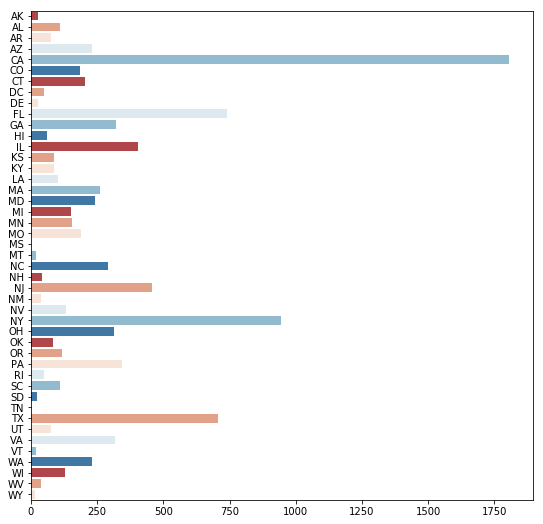

count    9999.000000
mean       18.993199
std        12.703174
min         0.000000
25%         6.000000
50%        17.000000
75%        29.000000
max        44.000000
Name: addr_state, dtype: float64


In [17]:
# Bar chart
fig, ax = plt.subplots(figsize=(9,9))
sns.barplot(x=df['addr_state'].value_counts().sort_index().tolist(), y = s_categories, palette=sns.color_palette("RdBu"))
plt.show()

#Summary
print(df['addr_state'].describe())

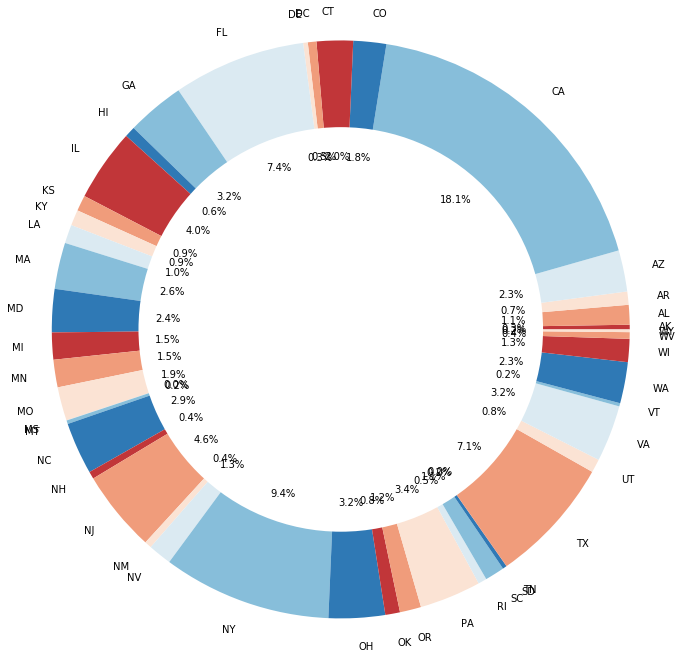

In [18]:
# Circle chart
fig, ax1 = plt.subplots(figsize=(9,9))
# fig = plt.figure(figsize=(10,10))
ax1.pie(df['addr_state'].value_counts().sort_index().tolist(),
        labels=s_categories,
        autopct='%1.1f%%',
        colors= sns.color_palette("RdBu"))

ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()

fig.gca().add_artist(centre_circle)
plt.tight_layout()

plt.show()